In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
train_ds = pd.read_csv('../dataset/train.csv')
val_ds   = pd.read_csv('../dataset/valid.csv')
test_ds  = pd.read_csv('../dataset/test.csv')

texts_train = train_ds['text']
y_train     = np.array(train_ds['label'])
texts_val   = val_ds['text']
y_val       = np.array(val_ds['label'])
texts_test  = test_ds['text']
y_test      = np.array(test_ds['label'])


encoder        = LabelEncoder()
y_train_enc    = encoder.fit_transform(y_train)
y_val_enc      = encoder.transform(y_val)
y_test_enc     = encoder.transform(y_test)
class_names    = encoder.classes_

In [3]:
max_vocab = 20000
max_len   = 100

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_sequence_length=max_len
)
vectorizer.adapt(texts_train)

In [4]:
X_train_tok = vectorizer(np.array(texts_train)).numpy()
X_val_tok   = vectorizer(np.array(texts_val)).numpy()
X_test_tok  = vectorizer(np.array(texts_test)).numpy()

In [5]:
def build_model(n_layers, units_list, bidirectional=False):
    inp = Input(shape=(max_len,), dtype='int64', name='tok_input')
    x   = Embedding(input_dim=max_vocab, output_dim=128, name='emb')(inp)
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        if bidirectional:
            x = Bidirectional(
                    LSTM(units_list[i], return_sequences=return_seq),
                    name=f'bi_lstm_{i}'
                )(x)
        else:
            x = LSTM(units_list[i], return_sequences=return_seq, name=f'lstm_{i}')(x)
        x = Dropout(0.5, name=f'dropout_{i}')(x)
    out = Dense(3, activation='softmax', name='pred')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam'
    )
    return model


In [6]:
def plot_loss(hist_dict, f1_dict, title_prefix):
    for name, hist in hist_dict.items():
        plt.figure()
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='val')
        plt.title(f'{title_prefix} {name}, F1={f1_dict[name]:.4f}')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

In [ ]:
layer_variants = [1, 2, 3]
hist_layers    = {}
f1_layers      = {}

for nl in layer_variants:
    units = [128] * nl
    name  = f'layers_{nl}'
    model = build_model(nl, units, bidirectional=True)
    history = model.fit(
        X_train_tok, y_train_enc,
        validation_data=(X_val_tok, y_val_enc),
        epochs=5,
        batch_size=64,
        verbose=0
    )
    preds = np.argmax(model.predict(X_test_tok), axis=1)
    f1    = f1_score(y_test_enc, preds, average='macro')
    hist_layers[name] = history
    f1_layers[name]   = f1
    model.save_weights(f'{name}.weights.h5')

plot_loss(hist_layers, f1_layers, 'Layer-count')
print('F1 per jumlah layer:', f1_layers)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
F1 per jumlah layer: {'layers_1': 0.637560941816261, 'layers_2': 0.6352341839930492, 'layers_3': 0.6672795756946428}


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step


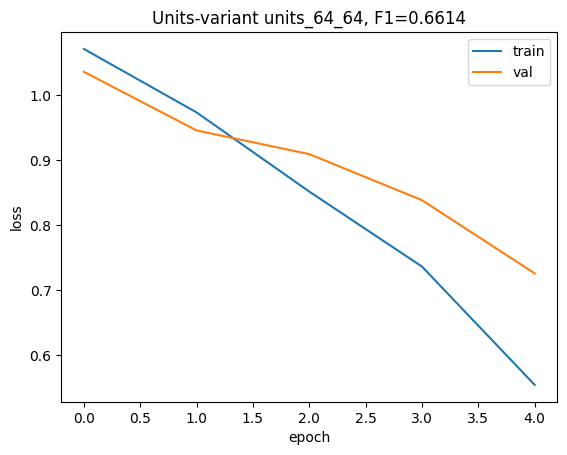

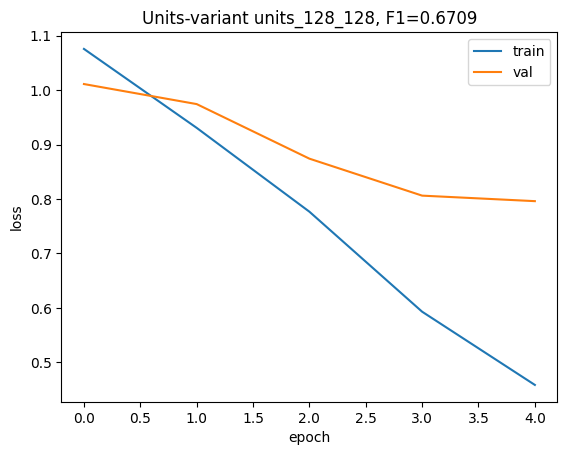

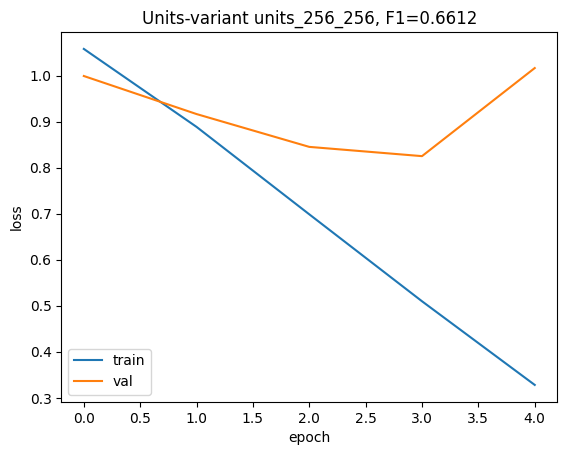

F1 per banyak cell: {'units_64_64': 0.6613726852147778, 'units_128_128': 0.670900397694267, 'units_256_256': 0.6612082034939811}


In [77]:
unit_variants = [[64,64], [128,128], [256,256]]
hist_units    = {}
f1_units      = {}

for units in unit_variants:
    name  = f'units_{"_".join(map(str, units))}'
    model = build_model(len(units), units, bidirectional=True)
    history = model.fit(
        X_train_tok, y_train_enc,
        validation_data=(X_val_tok, y_val_enc),
        epochs=5, batch_size=64, verbose=0
    )
    preds = np.argmax(model.predict(X_test_tok), axis=1)
    f1    = f1_score(y_test_enc, preds, average='macro')
    hist_units[name] = history
    f1_units[name]   = f1
    model.save_weights(f'{name}.weights.h5')

plot_loss(hist_units, f1_units, 'Units-variant')
print('F1 per banyak cell:', f1_units)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


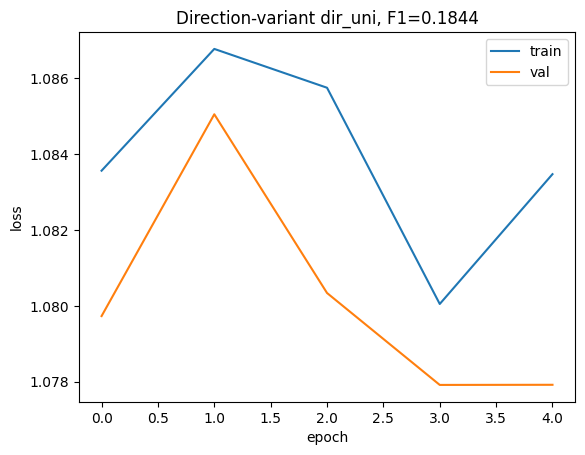

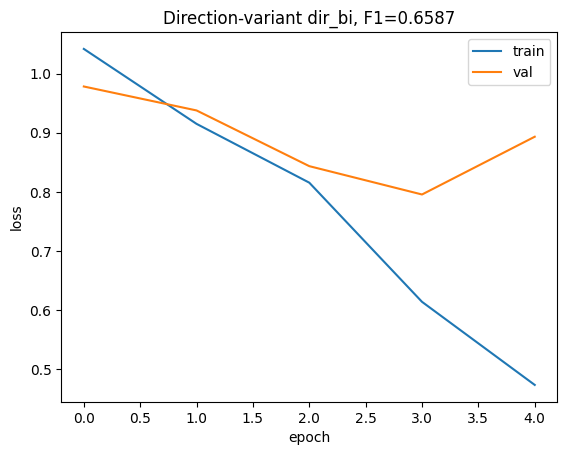

F1 per arah: {'dir_uni': 0.1844484629294756, 'dir_bi': 0.6586792589561273}


In [7]:
dir_variants = {'uni': False, 'bi': True}
hist_dir     = {}
f1_dir       = {}

for tag, bi in dir_variants.items():
    name  = f'dir_{tag}'
    model = build_model(2, [128,128], bidirectional=bi)
    history = model.fit(
        X_train_tok, y_train_enc,
        validation_data=(X_val_tok, y_val_enc),
        epochs=5, batch_size=64, verbose=0
    )
    preds = np.argmax(model.predict(X_test_tok), axis=1)
    f1    = f1_score(y_test_enc, preds, average='macro')
    hist_dir[name] = history
    f1_dir[name]   = f1
    model.save_weights(f'{name}.weights.h5')

plot_loss(hist_dir, f1_dir, 'Direction-variant')
print('F1 per arah:', f1_dir)


In [79]:
print('Hasil eksperimen lengkap:')
print(' - Layers:', f1_layers)
print(' - Units :', f1_units)
print(' - Arah  :', f1_dir)

Hasil eksperimen lengkap:
 - Layers: {'layers_1': 0.6510771504095362, 'layers_2': 0.5256735283495847, 'layers_3': 0.4901360996586426}
 - Units : {'units_64_64': 0.6613726852147778, 'units_128_128': 0.670900397694267, 'units_256_256': 0.6612082034939811}
 - Arah  : {'dir_uni': 0.1844484629294756, 'dir_bi': 0.5245881782945737}


# Scratch Vs Keras

In [35]:
import importlib
import classes.forward_lstm

importlib.reload(classes.forward_lstm)

from classes.forward_lstm import build_pipeline, predict


In [39]:
model = build_model(2, [128,128], bidirectional=True)
model.load_weights('layers_2.weights.h5')

pipeline = build_pipeline(model)

/Users/derwinrustanly/Code/Python/7-IF3270-CNN-RNN-LSTM/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
probs_keras   = model.predict(X_test_tok, verbose=0)
preds_keras   = np.argmax(probs_keras, axis=1)

probs_manual  = predict(pipeline, X_test_tok)
preds_manual  = np.argmax(probs_manual, axis=1)

In [41]:
f1_keras  = f1_score(y_test_enc, preds_keras, average='macro')
f1_manual = f1_score(y_test_enc, preds_manual, average='macro')

print(f'F1 macro  Keras  : {f1_keras:.4f}')
print(f'F1 macro  Manual : {f1_manual:.4f}')
print(f'Predictions identical rate: {np.mean(preds_keras == preds_manual):.3f}')

F1 macro  Keras  : 0.6352
F1 macro  Manual : 0.6352
Predictions identical rate: 1.000
